# Project - Computer Vision: Food 101

In this workbook, I will perform classification on a subset of the Food101 dataset. Our subset will only contain images of Pizza, Steak and Sushi. We will be using a random 20% of the data.

The workbook will contain the following workflow:
1. Data download
2. Understand and visualize the data
3. Transform the data and prepare train/test Dataset and train/test DataLoaders
4. Build a TinyVGG model - the structure found in the CNN Explainer website: https://poloclub.github.io/cnn-explainer/
5. Build a training loop
6. Train the TinyVGG model
7. Evaluate the TinyVGG model
8. Get pre-trained model 1: Efficient Net
9. Get pre-trained model 2: Vision Transformer (ViT)
10. Perform training on the pre-trained models by trying a set of different hyperparameters
11. Compare the models by visualizing them on Tensorboard
12. Save the two best performing models
13. Re-load one model of choice and make predictions on test data + custom data & visualize the results

In [82]:
# Let's install the main packages and libraries we will be using throughout the code
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import PIL
import pathlib
import random
import torchmetrics

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict
from timeit import default_timer as timer
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Let's also prepare a 'device' variable to have it ready for device-agnostic code - in case we will use a GPU in Colab
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Data Download

I will be getting the data from D.Bourke's GitHub: https://github.com/mrdbourke/pytorch-deep-learning

In [8]:
# Step 1: Prepare the data directory
base_dir = Path("data")
data_dir = base_dir / "Food101_20percent"

if data_dir.is_dir():
    print(f"Directory {data_dir} already exists!")
else:
    print(f"Directory {data_dir} does not exist, creating it now!")
    data_dir.mkdir(exist_ok=True, parents=True)

Directory data\Food101_20percent does not exist, creating it now!


In [9]:
# Step 2: Let's download the data into a zip file
with open(base_dir/"Food101_20percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip")
    f.write(request.content)
    print(f"Data is now downloaded and zipped")

Data is now downloaded and zipped


In [13]:
# Step 3: Unzipping the data into the data directory & deleting the zip file afterwards
with zipfile.ZipFile(base_dir/"Food101_20percent.zip", "r") as zip_ref:
    zip_ref.extractall(data_dir)
    print(f"Unzipping data to {data_dir}")
    
    
# Delete Zip file
os.remove(base_dir/"Food101_20percent.zip")

Unzipping data to data\Food101_20percent


Now data is downloaded and extracted into our data directory. The data structure follows the standard image classification structure - e.g., "train/class/sample_1.jpg"

## 2. Understanding the Data

Visualize to understand our data better!

In [57]:
# Let's create a function to plot random images (max 10)

def plot_images(train_directory: pathlib.Path, num_samples: int=5, seed: int=None):
    """
    Function to plot some random images from the training data directory. 
    The maximum will be 10 images at a time. Default is 5 images.
    """
    
    # 1. If num_samples > 10, default to 10 for visualization purposes
    if num_samples > 10:
        num_samples=10
        print(f"For visualization purposes, we only show up to 10 images max!")
    else:
        pass
    
    # 2. Get list of images in the data directory - assuming standard image classification data structure
    image_list = list(train_directory.glob("*/*.jpg"))
    
    # 3. Set random seed
    if seed:
        random.seed(seed)
    else:
        pass
    
    # 4. Choose random images
    images = random.sample(image_list, k=num_samples)
    
    # 5. Plot images:
    plt.figure(figsize=(10, 7))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = Image.open(images[i])
        img = np.asarray(img)
        plt.imshow(img)
        plt.title(images[i].parent.name)
        plt.axis(False)

In [58]:
train_dir = data_dir / "train"
train_dir

WindowsPath('data/Food101_20percent/train')

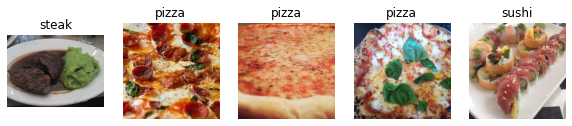

In [59]:
plot_images(train_directory=train_dir, num_samples=5)

## 3. Transform the data and prepare PyTorch Datasets and DataLoaders

To work with PyTorch, we need to convert our image data into tensors!

For this project, we will use simple transformations (resize and converting to tensor) without any data augmentation. 
Data augmentation is a solid approach to improve the results of a computer vision problem, but since we will use a small amount of data, we will not add augmentation at this step. 
We might try it later when we get the stronger pre-trained models!

In [60]:
# 1. Prepare the data transformation procedure
from torchvision import transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [61]:
# 2. Prepare the PyTorch Dataset using the ImageFolder() function built in torchvision.datasets
from torchvision import datasets

train_dir = data_dir / "train"
test_dir = data_dir / "test"

train_dataset = datasets.ImageFolder(root=train_dir, 
                                     transform=simple_transform, 
                                     target_transform=None) # No need to transform the labels

test_dataset = datasets.ImageFolder(root=test_dir, 
                                    transform=simple_transform, 
                                    target_transform=None)

print(f"Number of images found in training directory {train_dir} is: {len(train_dataset)}")
print(f"Number of images found in testing directory {test_dir} is: {len(test_dataset)}")

Number of images found in training directory data\Food101_20percent\train is: 450
Number of images found in testing directory data\Food101_20percent\test is: 150


In [63]:
# ImageFolder() also comes with other beneficial attributes, such as the 'classes' below:
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [65]:
# 3. Prepare the PyTorch DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=32, 
                              shuffle=True, 
                              num_workers=0, 
                              drop_last=True) # Drop last batch - would only contain 2 samples and could distort training

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=32, 
                             shuffle=False) # No need to shuffle the test data


print(f"Number of batches (size 32) in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches (size 32) in testing DataLoader: {len(test_dataloader)}")

Number of batches (size 32) in training DataLoader: 14
Number of batches (size 32) in testing DataLoader: 5


## 4. Build a TinyVGG model

In [77]:
# Will create a 'TinyVGG' class that subclasses 'nn.Module'
class TinyVGG(nn.Module):
    """Create a TinyVGG model architecture as shown in the CNN Explainer website"""
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        
        # 1. Create block 1:
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                                    out_channels=10, 
                                                    kernel_size=3, 
                                                    stride=1, 
                                                    padding=0), 
                                          nn.ReLU(), 
                                          nn.Conv2d(in_channels=10, 
                                                    out_channels=10, 
                                                    kernel_size=3, 
                                                    stride=1, 
                                                    padding=0), 
                                          nn.ReLU(), 
                                          nn.MaxPool2d(kernel_size=2))
        
        # 2. Create block 2:
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=10, 
                                                    out_channels=10, 
                                                    kernel_size=3, 
                                                    stride=1, 
                                                    padding=0), 
                                          nn.ReLU(), 
                                          nn.Conv2d(in_channels=10, 
                                                    out_channels=10, 
                                                    kernel_size=3, 
                                                    stride=1, 
                                                    padding=0), 
                                          nn.ReLU(), 
                                          nn.MaxPool2d(kernel_size=2))
        
        # 3. Create classifier layer
        self.classifier_layer = nn.Sequential(nn.Flatten(), 
                                              nn.Linear(in_features=53*53*10, 
                                                        out_features=num_classes))
        
    
    # 4. Define forward method
    def forward(self, x):
        x = self.classifier_layer(self.conv_block_2(self.conv_block_1(x)))
        return x

In [89]:
tiny_vgg_model = TinyVGG(in_channels=3, num_classes=len(class_names))
tiny_vgg_model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=3, bias=True)
  )
)

In [79]:
# Let's see a summary of our model to understand if the in_features in the classifier layer are correct
from torchinfo import summary

summary(model=tiny_vgg_model, 
        input_size=(1, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG (TinyVGG)                        [1, 3, 224, 224]     [1, 3]               --                   True
├─Sequential (conv_block_1)              [1, 3, 224, 224]     [1, 10, 110, 110]    --                   True
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 10, 222, 222]    280                  True
│    └─ReLU (1)                          [1, 10, 222, 222]    [1, 10, 222, 222]    --                   --
│    └─Conv2d (2)                        [1, 10, 222, 222]    [1, 10, 220, 220]    910                  True
│    └─ReLU (3)                          [1, 10, 220, 220]    [1, 10, 220, 220]    --                   --
│    └─MaxPool2d (4)                     [1, 10, 220, 220]    [1, 10, 110, 110]    --                   --
├─Sequential (conv_block_2)              [1, 10, 110, 110]    [1, 10, 53, 53]      --                   True
│    └─Conv2d (0)   

Great!

## 5. Build a complete Training Loop

We will write three functions:
1. `train_step()` - this function will perform the training step (optimization)
2. `test_step()` - this function will perform the model evaluation on the test data
3. `train()` - this function will be the consolidated function that will be comprised of both the `train_step()` and `test_step()` functions, and will produce results in the form of a dictionary. It will also contain logs such that we can compare models with Tensorboard later

In [86]:
def train_step(model: torch.nn.Module, 
               train_dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn, 
               optimizer: torch.optim, 
               accuracy_fn: torchmetrics, 
               device: torch.device):
    """Complete one training iteration over the training DataLoader"""
    
    # 1. Turn model in training mode
    model.train()
    
    # 2. Create variables for train loss and accuracy
    train_loss, train_acc = 0, 0
    
    # 3. Start training
    for batch, (X, y) in enumerate(train_dataloader):
        
        # 4. Put data into target device
        X, y = X.to(device), y.to(device)
        
        # 5. Compute training predictions
        y_logits = model(X)
        y_pred_prob = torch.softmax(y_logits, dim=1)
        y_pred_label = torch.argmax(y_pred_prob, dim=1)
        
        # 6. Compute loss and accuracy
        loss = loss_fn(y_pred_prob, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred_label, y)
        
        # 7. Optimizer zero grad
        optimizer.zero_grad()
        
        # 8. Compute gradients - Backpropagation
        loss.backward()
        
        # 9. Optimizer step
        optimizer.step()
        
    
    # Compute loss per batch
    train_loss = train_loss / len(train_dataloader)
    
    # Compute accuracy per batch
    train_acc = train_acc / len(train_dataloader)
    
    return train_loss, train_acc

In [96]:
def test_step(model: torch.nn.Module, 
              test_dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn, 
              accuracy_fn: torchmetrics, 
              device: torch.device):
    """Complete one evaluation step through the testing DataLoader"""
    
    # 0. Initialize test and accuracy variables
    test_loss, test_acc = 0, 0
    
    # 1. Turn the model into evaluation mode
    model.eval()
    
    # 2. Start evaluation process:
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            
            # 3. Put data into target device
            X, y = X.to(device), y.to(device)
            
            # 4. Compute predictions
            y_test_logits = model(X)
            y_test_probs = torch.softmax(y_test_logits, dim=1)
            y_test_label = torch.argmax(y_test_probs, dim=1)
            
            # 5. Compute loss and accuracy
            test_loss += loss_fn(y_test_probs, y)
            test_acc += accuracy_fn(y_test_label, y)
            
        
    # Compute loss per batch
    test_loss = test_loss / len(test_dataloader)

    # Compute accuracy per batch
    test_acc = test_acc / len(test_dataloader)

    return test_loss, test_acc
            

In [85]:
# Let's also build a helper function that creates SummaryWriter() instance in a target log directory - from D.Bourke course
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a SummaryWriter() instance to a specified log directory
    
    The log directory (log_dir) is a combination of runs/timestamp/experiment_name/model_name/extra
    
    timestamp ~ the current date in YYYY-MM-DD format
    
    Example usage:
        # Create a writer saving to "runs/2024-12-23/data_20_percent/tinyvgg/5_epochs/"
        writer = create_writer(experiment_name="data_20_percent",
                               model_name="tinyvgg",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2024-12-23/data_20_percent/tinyvgg/5_epochs/")
    
    """
    from datetime import datetime
    import os
    
    # Get timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format
    
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}!")
    return SummaryWriter(log_dir=log_dir)

In [165]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          epochs: int, 
          loss_fn: torch.nn, 
          optimizer: torch.optim, 
          accuracy_fn: torchmetrics, device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter=None):
    """Consolidated training function
    
    Args:
        model ~ the model which we will be training and evaluating
        train_dataloader ~ the DataLoader we will use to train and optimize the model
        test_dataloader ~ the DataLoader we will use to evaluate the model
        epochs ~ the number of epochs for which we will train the model
        loss_fn ~ the loss function we will use to estimate how wrong our model predictions are
        optimizer ~ the optimization procedure we will take to improve our model
        accuracy_fn ~ the accuracy metric we will look at during training/evaluation
        writer ~ the log directory in which we will store the model results to review on Tensorboard
    
    Output:
        Will produce a dictionary of lists that contains the results: train/test loss, train/test accuracy, 
        time to train.
    
    """
    # 1. Let's initialize the results dictionary
    results = {"train_loss":[], 
               "train_acc":[], 
               "test_loss":[], 
               "test_acc":[]}
    
    # 2. Start the loop
    for epoch in tqdm(range(epochs)):
        # 3. Training step
        train_loss, train_acc = train_step(model=model, 
                                           train_dataloader=train_dataloader, 
                                           loss_fn=loss_fn, 
                                           optimizer=optimizer, 
                                           accuracy_fn=accuracy_fn, 
                                           device=device)
        # 4. Testing step
        test_loss, test_acc = test_step(model=model, 
                                        test_dataloader=test_dataloader, 
                                        loss_fn=loss_fn, 
                                        accuracy_fn=accuracy_fn, 
                                        device=device)
        
        # 5. Print out what's happening
        print(f"Epoch: {epoch+1}")
        print(f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%")
        print(f"Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%")
        print("-----------------------------------------------------------------")
    
        # 6. Append the results to the 'results' dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        
        
        # 7. If there is a writer, log to it:
        if writer:
            # Add results to the SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss, 
                                                "test_loss": test_loss}, 
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc, 
                                                "test_acc": test_acc}, 
                               global_step=epoch)
            # Close the writer
            writer.close()
        else:
            pass
        
    
    # Return results
    return results

## 6. Train the TinyVGG model

In [99]:
tiny_vgg_model = TinyVGG(in_channels=3, num_classes=len(class_names))

In [100]:
# 1. Select loss function, optimizer, and accuracy function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=tiny_vgg_model.parameters(), 
                                lr=0.003)
acc_fn = torchmetrics.Accuracy(task='multiclass', 
                               num_classes=len(class_names))

In [101]:
# 2. Create a writer for the base model - we don't expect this model to have strong performance
base_writer = create_writer(experiment_name='data_20_percent', model_name='tinyvgg', extra='5_epochs\\base_model')
base_writer

[INFO] Created SummaryWriter, saving to: runs\2024-12-23\data_20_percent\tinyvgg\5_epochs\base_model!


In [102]:
# 2. Let's select the number of epochs and train our TinyVGG model. Also, time the time it takes to train

NUM_EPOCHS = 5

start_time = timer()

results = train(model=tiny_vgg_model, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader, 
                epochs=NUM_EPOCHS, 
                loss_fn=loss_fn, 
                optimizer=optimizer, 
                accuracy_fn=acc_fn, 
                device=device, 
                writer=base_writer)

end_time = timer()

print(f"Time to train base model (TinyVGG): {(end_time - start_time):.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 1.207, Train Acc: 33.26%
Test Loss: 1.264, Test Acc: 28.75%
-----------------------------------------------------------------


 20%|██        | 1/5 [00:17<01:10, 17.53s/it]

Epoch: 2
Train Loss: 1.212, Train Acc: 33.93%
Test Loss: 1.264, Test Acc: 28.75%
-----------------------------------------------------------------


 40%|████      | 2/5 [00:39<01:01, 20.43s/it]

Epoch: 3
Train Loss: 1.208, Train Acc: 34.38%
Test Loss: 1.264, Test Acc: 28.75%
-----------------------------------------------------------------


 60%|██████    | 3/5 [01:02<00:43, 21.58s/it]

Epoch: 4
Train Loss: 1.210, Train Acc: 34.15%
Test Loss: 1.264, Test Acc: 28.75%
-----------------------------------------------------------------


 80%|████████  | 4/5 [01:26<00:22, 22.19s/it]

Epoch: 5
Train Loss: 1.210, Train Acc: 34.15%
Test Loss: 1.264, Test Acc: 28.75%
-----------------------------------------------------------------


100%|██████████| 5/5 [01:49<00:00, 21.86s/it]

Time to train base model (TinyVGG): 109.29 seconds


## 7. Pre-Trained Model 1: Efficient Net

I will be creating a function to create a new instance of EffNet_B0 since we will train and evaluate the model with various hyperparameters shortly.

In [109]:
def create_effnet_b0(feature_extractor: bool=True, num_classes: int=3):
    """Create an instance of EfficientNet_B0 model
    
    Args:
        feature_extractor ~ describe whether the model will be used as a feature extractor, or for further fine-tuning
        num_classes ~ the number of output classes in the classification task
    
    """
    # 0. Import packages/libraries
    import torchvision
    import torch
    
    from torchvision import models
    from torch import nn
    
    # 1. Choose weights
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    
    # 2. Get the data transformation with which EffNet_B0 model was trained on
    data_transform = weights.transforms()
    
    # 3. Create model and apply weights from step 1
    model = torchvision.models.efficientnet_b0(weights=weights)
    
    # 4. If we will use the pre-trained model as a feature extractor model, freeze all feature layers
    if feature_extractor == True:
        for param in model.features.parameters():
            param.requires_grad = False
    else:
        pass
    
    # 5. Adapt the classifier layer to our classification problem
    model.classifier = torch.nn.Sequential(nn.Dropout(p=0.2, 
                                                      inplace=True), 
                                           nn.Linear(in_features=1280, 
                                                     out_features=num_classes, 
                                                     bias=True)).to(device)
    
    return model, data_transform

In [128]:
sample_effnet_b0, effnet_transform = create_effnet_b0(feature_extractor=True, num_classes=3)

In [129]:
effnet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [127]:
summary(sample_effnet_b0, 
        input_size=(1, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    │    └─MBConv (0)                                       [1, 32, 112, 112]    [1, 16, 112, 112]    False
│    └─Sequentia

## 8. Pre-Trained Model 2: Vision Transformer

Similarly, I will create a function to generate an instance of a ViT model. For ViT, we will test two different weight groups: DEFAULT, and IMAGENET1K_SWAG_E2E_V1

In [124]:
def create_ViT(feature_extractor: bool=True, num_classes: int=3, weights: str='DEFAULT'):
    """Create an instance of the Vision Transformer architecture
    
    Args:
        feature_extractor ~ describe whether the model will be used as a feature extractor, or for further fine-tuning
        num_classes ~ the number of output classes in the classification task
        weights ~ either 'DEFAULT' or 'IMAGENET1K_SWAG_E2E_V1'. The weights will default to 'DEFAULT'
    
    """
    # 0. Import packages/libraries
    import torchvision
    import torch
    
    from torchvision import models
    from torch import nn
    
    # 1. Get weights
    print(f"Weights: {weights} -- {weights=='IMAGENET1K_SWAG_E2E_V1'}")
    if weights == 'IMAGENET1K_SWAG_E2E_V1':
        weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
    else:
        weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        
    # 2. Get the data transformation
    data_transform = weights.transforms()
    
    # 3. Create model instance and apply weights from step 1
    model = torchvision.models.vit_b_16(weights=weights)
    
    # 4. If the model is a feature extractor model, freeze all layers except the final classification block
    if feature_extractor == True:
        for param in model.parameters():
            param.requires_grad = False
    else:
        pass
    
    # 5. Adapt the classifier block for our classification problem
    model.heads = nn.Linear(in_features=768, 
                            out_features=num_classes).to(device)

    
    return model, data_transform

In [137]:
# Let's try our function to get the ViT model with DEFAULT weights - DEFAULT means the best weights so far on this model
sample_vit_default, vit_transform_default = create_ViT(feature_extractor=True, 
                                                       num_classes=3, 
                                                       weights='DEFAULT')

Weights: DEFAULT -- False


In [126]:
# Let's check the summary for the ViT model using the DEFAULT weights
summary(sample_vit_default, 
        input_size=(1, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]        [1, 197, 768]        False
│    │    └─Enco

In [138]:
# Let's also check the other option for weights - using IMAGENET1K_SWAG_E2E_V1
sample_vit_imagenet, vit_transform_imagenet = create_ViT(feature_extractor=True, 
                                                         num_classes=3, 
                                                         weights='IMAGENET1K_SWAG_E2E_V1')

Weights: IMAGENET1K_SWAG_E2E_V1 -- True


In [132]:
summary(sample_vit_imagenet, 
        input_size=(1, 3, 384, 384), # Note that it requires different image shape (384x384 pixels)
        col_names=['input_size', 'output_size', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 577, 768]        False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 577, 768]        [1, 577, 768]        False
│    │    └─Enco

## 9. Perform training on the pre-trained models

Procedure:
1. Prepare the PyTorch Dataset using the appropriate data transformations
2. Prepare the DataLoaders for each model
3. Choose the set of different hyperparameters we will try
4. Perform training

In [142]:
# 1. Check if any of the data transforms for the 3 pre-trained model are the same
effnet_transform, vit_transform_default, vit_transform_imagenet

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ),
 ImageClassification(
     crop_size=[384]
     resize_size=[384]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

Seems not!

**Datasets & DataLoaders for EfficientNet model**

In [147]:
train_dataset_effnet = torchvision.datasets.ImageFolder(root=train_dir, 
                                                        transform=effnet_transform, 
                                                        target_transform=None)

test_dataset_effnet = torchvision.datasets.ImageFolder(root=test_dir, 
                                                       transform=effnet_transform, 
                                                       target_transform=None)

# Quick test
len(train_dataset_effnet) == len(train_dataset), len(test_dataset_effnet) == len(test_dataset)

(True, True)

In [148]:
# Let's prepare the DataLoaders
train_dataloader_effnet = DataLoader(dataset=train_dataset_effnet, 
                                     batch_size=32, 
                                     shuffle=True, 
                                     drop_last=True)

test_dataloader_effnet = DataLoader(dataset=test_dataset_effnet, 
                                    batch_size=32, 
                                    shuffle=False, 
                                    drop_last=False)

# Quick test
len(train_dataloader_effnet)==len(train_dataloader), len(test_dataloader_effnet)==len(test_dataloader)

(True, True)

**Datasets & DataLoaders for ViT model with DEFAULT weights**

In [149]:
train_dataset_vit_default = torchvision.datasets.ImageFolder(root=train_dir, 
                                                             transform=vit_transform_default, 
                                                             target_transform=None)

test_dataset_vit_default = torchvision.datasets.ImageFolder(root=test_dir, 
                                                            transform=vit_transform_default, 
                                                            target_transform=None)

# Quick test
len(train_dataset_vit_default) == len(train_dataset), len(test_dataset_vit_default) == len(test_dataset)

(True, True)

In [150]:
# Let's prepare the DataLoaders
train_dataloader_vit_default = DataLoader(dataset=train_dataset_vit_default, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          drop_last=True)

test_dataloader_vit_default = DataLoader(dataset=test_dataset_vit_default, 
                                         batch_size=32, 
                                         shuffle=False, 
                                         drop_last=False)

# Quick test
len(train_dataloader_vit_default)==len(train_dataloader), len(test_dataloader_vit_default)==len(test_dataloader)

(True, True)

**Datasets & DataLoaders for ViT model with IMAGENET1K_SWAG_E2E_V1 weights**

In [151]:
train_dataset_vit_imagenet = torchvision.datasets.ImageFolder(root=train_dir, 
                                                              transform=vit_transform_imagenet, 
                                                              target_transform=None)

test_dataset_vit_imagenet = torchvision.datasets.ImageFolder(root=test_dir, 
                                                             transform=vit_transform_imagenet, 
                                                             target_transform=None)

# Quick test
len(train_dataset_vit_imagenet) == len(train_dataset), len(test_dataset_vit_imagenet) == len(test_dataset)

(True, True)

In [152]:
# Let's prepare the DataLoaders
train_dataloader_vit_imagenet = DataLoader(dataset=train_dataset_vit_imagenet, 
                                           batch_size=32, 
                                           shuffle=True, 
                                           drop_last=True)

test_dataloader_vit_imagenet = DataLoader(dataset=test_dataset_vit_imagenet, 
                                          batch_size=32, 
                                          shuffle=False, 
                                          drop_last=False)

# Quick test
len(train_dataloader_vit_imagenet)==len(train_dataloader), len(test_dataloader_vit_imagenet)==len(test_dataloader)

(True, True)

**Now, let's choose the sets of hyperparameters that we will try out**

What we will be changing:
* Epochs: 5, 10
* Optimizer: Adam, RMSProp
* Learning Rate: Default, 0.003


In [155]:
# Prepare list for number of epochs we will try out
num_epochs = [5, 10]

# Prepare list for optimizers we will try out
optimizer_list = ['Adam', 'RMSProp']

# Prepare list for the different learning rates we will try out
lr_list = ['Default', 0.003]

# Models list
models = ['effnet_b0', 'vit_default', 'vit_imagenet']

In [166]:
# 1. Set random seeds
random.seed(42)
torch.manual_seed(42)

# 2. Track experiment number
experiment_number = 0

# 3. Loop through the num_epochs list:
for epochs in num_epochs:
    
    # 4. Loop through the optimizer_list:
    for optimizer_choice in optimizer_list:
        
        # 5. Loop through the learning rates
        for learning_rate in lr_list:
            
            # 6. Loop through each model
            for model_choice in models:
                
                # 7. Create information print outs
                experiment_number += 1
                print(f"[INFO] Experiment number: {experiment_number}")
                print(f"[INFO] Model choice: {model_choice}")
                print(f"[INFO] Optimizer: {optimizer_choice}")
                print(f"[INFO] Learning Rate: {learning_rate}")
                
                
                # 8. Setup model
                if model_choice == 'effnet_b0':
                    model, _ = create_effnet_b0(feature_extractor=True, 
                                                num_classes=3)
                    train_dataloader = train_dataloader_effnet
                    test_dataloader = test_dataloader_effnet
                    
                elif model_choice == 'vit_default':
                    model, _ = create_ViT(feature_extractor=True, 
                                          num_classes=3, 
                                          weights='DEFAULT')
                    train_dataloader = train_dataloader_vit_default
                    test_dataloader = test_dataloader_vit_default
                    
                else:
                    model, _ = create_ViT(feature_extractor=True, 
                                          num_classes=3, 
                                          weights='IMAGENET1K_SWAG_E2E_V1')
                    train_dataloader = train_dataloader_vit_imagenet
                    test_dataloader = test_dataloader_vit_imagenet
                    
                
                # 9. Setup optimizer
                if optimizer_choice == 'Adam':
                    if learning_rate == 0.003:
                        optimizer = torch.optim.Adam(params=model.parameters(), 
                                                     lr=learning_rate)
                    else:
                        optimizer = torch.optim.Adam(params=model.parameters())
                else:
                    if learning_rate == 0.003:
                        optimizer = torch.optim.RMSprop(params=model.parameters(), 
                                                        lr=learning_rate)
                    else:
                        optimizer = torch.optim.RMSprop(params=model.parameters())
                
                
                # 10. Setup loss function, optimizer, accuracy function
                loss_fn = torch.nn.CrossEntropyLoss()
                acc_fn = torchmetrics.Accuracy(task='multiclass', 
                                               num_classes=3)
                
                
                # 11. Train model
                train(model=model, 
                      train_dataloader=train_dataloader, 
                      test_dataloader=test_dataloader, 
                      epochs=epochs, 
                      loss_fn=loss_fn, 
                      optimizer=optimizer, 
                      accuracy_fn=acc_fn, 
                      device=device, 
                      writer=create_writer(experiment_name=f"{epochs}epochs", 
                                           model_name=model_choice, 
                                           extra=os.path.join(optimizer_choice, f"lr_{learning_rate}")))
                
                
                # 12. Save the models such that we can re-load the best ones later
                save_filepath = f"models/Model_{experiment_number}_{model_choice}_{epochs}epochs_{optimizer_choice}_{learning_rate}.pth"
                torch.save(obj=model.state_dict(), 
                           f=save_filepath)
                print("-"*50 + "\n")
                
                
                

  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Experiment number: 1
[INFO] Model choice: effnet_b0
[INFO] Optimizer: Adam
[INFO] Learning Rate: Default
[INFO] Created SummaryWriter, saving to: runs\2024-12-23\5epochs\effnet_b0\Adam\Default!


 20%|██        | 1/5 [00:35<02:21, 35.50s/it]

Epoch: 1
Train Loss: 1.042, Train Acc: 58.71%
Test Loss: 0.917, Test Acc: 88.18%
-----------------------------------------------------------------


 40%|████      | 2/5 [01:17<01:58, 39.33s/it]

Epoch: 2
Train Loss: 0.908, Train Acc: 81.70%
Test Loss: 0.837, Test Acc: 90.97%
-----------------------------------------------------------------


 60%|██████    | 3/5 [01:54<01:16, 38.44s/it]

Epoch: 3
Train Loss: 0.840, Train Acc: 84.60%
Test Loss: 0.787, Test Acc: 91.59%
-----------------------------------------------------------------


 80%|████████  | 4/5 [02:32<00:38, 38.09s/it]

Epoch: 4
Train Loss: 0.797, Train Acc: 87.72%
Test Loss: 0.760, Test Acc: 91.36%
-----------------------------------------------------------------


100%|██████████| 5/5 [03:14<00:00, 38.98s/it]

Epoch: 5
Train Loss: 0.763, Train Acc: 89.06%
Test Loss: 0.735, Test Acc: 93.18%
-----------------------------------------------------------------
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model choice: vit_default
[INFO] Optimizer: Adam
[INFO] Learning Rate: Default
Weights: DEFAULT -- False



  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Created SummaryWriter, saving to: runs\2024-12-23\5epochs\vit_default\Adam\Default!


 20%|██        | 1/5 [03:24<13:38, 204.64s/it]

Epoch: 1
Train Loss: 0.886, Train Acc: 77.90%
Test Loss: 0.692, Test Acc: 96.88%
-----------------------------------------------------------------


 40%|████      | 2/5 [06:48<10:11, 203.95s/it]

Epoch: 2
Train Loss: 0.667, Train Acc: 93.53%
Test Loss: 0.619, Test Acc: 98.75%
-----------------------------------------------------------------


 60%|██████    | 3/5 [10:10<06:46, 203.19s/it]

Epoch: 3
Train Loss: 0.628, Train Acc: 94.87%
Test Loss: 0.599, Test Acc: 98.75%
-----------------------------------------------------------------


 80%|████████  | 4/5 [13:31<03:22, 202.48s/it]

Epoch: 4
Train Loss: 0.614, Train Acc: 95.54%
Test Loss: 0.590, Test Acc: 98.75%
-----------------------------------------------------------------


100%|██████████| 5/5 [16:54<00:00, 202.82s/it]

Epoch: 5
Train Loss: 0.605, Train Acc: 96.21%
Test Loss: 0.585, Test Acc: 98.75%
-----------------------------------------------------------------


--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model choice: vit_imagenet
[INFO] Optimizer: Adam
[INFO] Learning Rate: Default
Weights: IMAGENET1K_SWAG_E2E_V1 -- True


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Created SummaryWriter, saving to: runs\2024-12-23\5epochs\vit_imagenet\Adam\Default!


 20%|██        | 1/5 [11:28<45:52, 688.19s/it]

Epoch: 1
Train Loss: 0.757, Train Acc: 83.71%
Test Loss: 0.573, Test Acc: 99.09%
-----------------------------------------------------------------


 40%|████      | 2/5 [1:51:22<3:10:28, 3809.47s/it]

Epoch: 2
Train Loss: 0.572, Train Acc: 99.11%
Test Loss: 0.557, Test Acc: 100.00%
-----------------------------------------------------------------


 60%|██████    | 3/5 [2:03:34<1:20:08, 2404.21s/it]

Epoch: 3
Train Loss: 0.565, Train Acc: 99.11%
Test Loss: 0.555, Test Acc: 100.00%
-----------------------------------------------------------------


 80%|████████  | 4/5 [2:15:51<29:06, 1746.17s/it]  

Epoch: 4
Train Loss: 0.562, Train Acc: 99.55%
Test Loss: 0.555, Test Acc: 100.00%
-----------------------------------------------------------------


100%|██████████| 5/5 [2:28:03<00:00, 1776.74s/it]

Epoch: 5
Train Loss: 0.560, Train Acc: 99.55%
Test Loss: 0.554, Test Acc: 100.00%
-----------------------------------------------------------------


--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model choice: effnet_b0
[INFO] Optimizer: Adam
[INFO] Learning Rate: 0.003


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'float'

In [171]:
tensorboard --inspect --logdir runs/2024-12-23

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Contents of stdout:
Processing event files... (this can take a few minutes)

Found event files in:
runs/2024-12-23\5epochs\effnet_b0\Adam\Default
runs/2024-12-23\5epochs\effnet_b0\Adam\Default\Accuracy_test_acc
runs/2024-12-23\5epochs\effnet_b0\Adam\Default\Accuracy_train_acc
runs/2024-12-23\5epochs\effnet_b0\Adam\Default\Loss_test_loss
runs/2024-12-23\5epochs\effnet_b0\Adam\Default\Loss_train_loss
runs/2024-12-23\5epochs\vit_default\Adam\Default
runs/2024-12-23\5epochs\vit_default\Adam\Default\Accuracy_test_acc
runs/2024-12-23\5epochs\vit_default\Adam\Default\Accuracy_train_acc
runs/2024-12-23\5epochs\vit_default\Adam\Default\Loss_test_loss
runs/2024-12-23\5epochs\vit_default\Adam\Default\Loss_train_loss
runs/2024-12-23\5epochs\vit_imagenet\Adam\Default
runs/2024-12-23\5epochs\vit_imagenet\Adam\Default\Accuracy_test_acc
runs/2024-12-23\5epochs\

In [190]:
%reload_ext tensorboard
%tensorboard --logdir runs --port 6007

We can see that the ViT models perform very strongly on the data, but they take a long time to train (on a single CPU that I am using). Especially the ViT model with IMAGENET weights appears to take about 3 hours to train for 5 epochs.

Let's now get the ViT_Default model and use it to make some predictions on the test data, and also some custom data from the internet.

In [192]:
# 1. Create model instance
final_model, _ = create_ViT()

Weights: DEFAULT -- False


In [194]:
# 2. Model of choice: ViT_Default with Adam optimizer & default learning rate and optimizer parameters
model_path = 'models/Model_2_vit_default_5epochs_Adam_Default.pth'

# 3. Get weights from the model path we've saved above
final_model.load_state_dict(torch.load(f=model_path))

<All keys matched successfully>

In [249]:
# Let's create a function to predict & plot random images (max 10)

def pred_plot_images(model: torch.nn.Module, 
                     data_directory: pathlib.Path,
                     data_transform: torchvision.transforms,
                     classes: list=None, 
                     num_samples: int=5, 
                     random_select: bool=True,
                     image_idx: list=None,
                     seed: int=None):
    """
    Function to predict and plot some random images from the specified data directory. 
    
    Args:
        model ~ the model with which we will make the predictions
        data_directory ~ the directory from which we will get the images
        data_transform ~ the transformation that will be applied to the images prior to running the model on them
        classes ~ the classification labels to choose from. If not supplied, will predict as numbers (i.e., class 1, 2 etc.)
        num_samples ~ the number of predictions we want to make in one run of the function (max is 10, default is 5)
        random_select ~ if True, the images will be selected at random
        image_idx ~ if `random_select=False`, supply list of indexes about which images we want to look at
        seed ~ random seed for replication
    """    
    
    # 1. If num_samples > 10, default to 10 for visualization purposes
    if num_samples > 10:
        num_samples=10
        print(f"For visualization purposes, we only show up to 10 images max!")
    else:
        pass
    
    
    # 2. Get list of images in the data directory - assuming standard image classification data structure
    image_list = list(data_directory.glob("*/*.jpg"))
    
    
    # 3. Set random seed
    if seed:
        random.seed(seed)
        torch.manual_seed(seed)
    else:
        pass
    
    
    # 4. Choose images
    if random_select==True:
        images = random.sample(image_list, k=num_samples)
    else:
        # 1. Make assertion that if random_select=False, image_idx should contain num_samples images
        assert len(image_idx)==num_samples
        # 2. Get images list
        images = [image_list[i] for i in image_idx]
    
   
    
    # 7. Plot images & predicted values:
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        
        # 1. Create subplot & plot image
        plt.subplot(num_samples, 1, i+1)
        img = Image.open(images[i])
        plt.imshow(img)
        
        
        # 2. Transform image
        img_transformed = data_transform(img)
        
        
        # 3. Make prediction
        model.eval()
        with torch.inference_mode():
            y_logits = model(img_transformed.unsqueeze(0))
            y_pred_probs = torch.softmax(y_logits, dim=1)
            y_pred_label = torch.argmax(y_pred_probs, dim=1)
        
        
        # 4. Get true and predicted label
        img_label = images[i].parent.name
        pred_label = classes[y_pred_label] if classes else y_pred_label
        if classes:
            if img_label == pred_label:
                title = f"True Label: {img_label} | Pred Label: {pred_label}\nImage: {images[i].name}"
                plt.title(title, c='g')
            else:
                title = f"True Label: {img_label} | Pred Label: {pred_label}\nImage: {images[i].name}"
                plt.title(title, c='r')
        else:
            title = f"True Label: {img_label} | Pred Label: {pred_label}"
            plt.title(title)
            plt.suptitle(images[i].name)
        
        plt.axis(False)
        
    plt.tight_layout()
    plt.show()

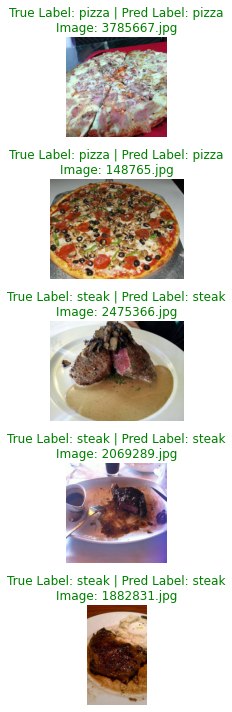

In [251]:
pred_plot_images(model=final_model, 
                 data_directory=test_dir, 
                 data_transform=vit_transform_default, 
                 classes=class_names, 
                 num_samples=5, 
                 seed=42)

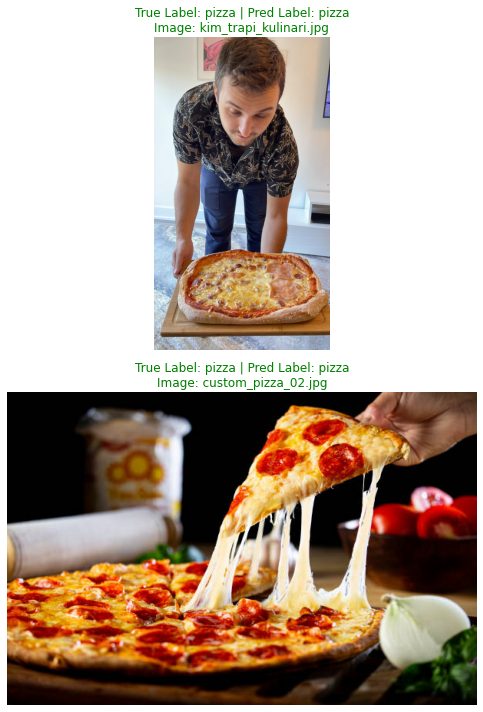

In [257]:
# Let's try it on some custom images I've downloaded from the internet (and one is my brother)
custom_dir = Path('data/Custom_Data')

pred_plot_images(model=final_model, 
                 data_directory=custom_dir, 
                 data_transform=vit_transform_default, 
                 classes=class_names, 
                 num_samples=2, 
                 seed=42)

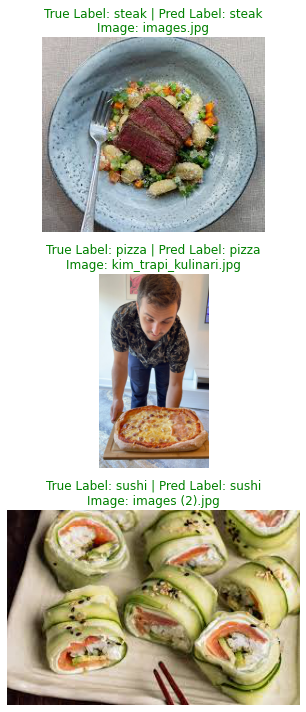

In [258]:
pred_plot_images(model=final_model, 
                 data_directory=custom_dir, 
                 data_transform=vit_transform_default, 
                 classes=class_names, 
                 num_samples=3)